# Building formation solver using cython, featuring flood fill and convolution algorithms.

## Example of how to use flood fill algorithm in the context of a Starcraft bot
This is useful if you want to find all similar points at a given location, for example find all points in our main base location

In this notebook we want all similar points near an expansion location, so we know the limits of the building formation.

In [1]:
# Change path as needed
MAP_PATH = "../tests/pickle_data/HardwireAIE.xz"

In [2]:
# load cell magic things
%load_ext line_profiler
%load_ext Cython

In [3]:
# imports
import matplotlib.pyplot as plt
import numpy as np

from sc2.ids.unit_typeid import UnitTypeId
from sc2.bot_ai import BotAI
from sc2.position import Point2
from sc2.dicts.unit_trained_from import UNIT_TRAINED_FROM
from sc2.game_info import Race
from sc2.unit import Unit
from sc2.units import Units

from tests.load_bot_from_pickle import get_map_specific_bot

In [4]:
# setup a burnysc2 BOTAI instance we can test with
bot: BotAI = get_map_specific_bot(MAP_PATH)

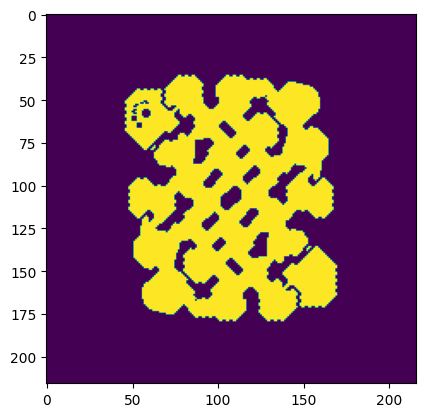

In [5]:
# sanity check that the bot instance is working
plt.imshow(bot.game_info.pathing_grid.data_numpy)

In [6]:
start_point=bot.enemy_start_locations[0].rounded
terrain_grid=bot.game_info.terrain_height.data_numpy.T
pathing_grid=bot.game_info.pathing_grid.data_numpy.T
max_distance=20

## Flood fill
### Note the cutoff_points parameter, add a set of `Point2` for any points we do not want the algorithm to go through such as choke points

In [7]:
%%cython
from cython cimport boundscheck, wraparound

cdef unsigned int euclidean_distance_squared_int((unsigned int, unsigned int) p1, (unsigned int, unsigned int) p2):
    return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2

cpdef set flood_fill(
    (unsigned int, unsigned int) start_point, 
    const unsigned char[:, :] terrain_grid, 
    const unsigned char[:, :] pathing_grid, 
    unsigned int max_distance, 
    set cutoff_points
):
    cdef:
        unsigned int terrain_height = terrain_grid[start_point[0], start_point[1]]
        unsigned int pathing_value = pathing_grid[start_point[0], start_point[1]]
        set filled_points = set()

    # Only continue if we can get a height for the starting point
    if not terrain_height:
        return filled_points
    
    if pathing_value != 1:
        return filled_points
        
    grid_flood_fill(start_point, terrain_grid, pathing_grid, terrain_height, filled_points, start_point, max_distance, cutoff_points)
    return filled_points

cdef set grid_flood_fill(
    (unsigned int, unsigned int) point, 
    const unsigned char[:, :] terrain_grid, 
    const unsigned char[:, :] pathing_grid, 
    unsigned int target_val, 
    set current_vec, 
    (unsigned int, unsigned int) start_point, 
    unsigned int max_distance, 
    set cutoff_points):
    cdef:
        unsigned int terrain_height = terrain_grid[start_point[0], start_point[1]]
        unsigned int pathing_value = pathing_grid[start_point[0], start_point[1]]
    # Check that we haven't already added this point.
    if point in current_vec:
        return current_vec

    # Check that this point isn't too far away from the start
    if euclidean_distance_squared_int(point, start_point) > max_distance ** 2:
        return current_vec

    if point in cutoff_points:
        return current_vec

    terrain_height = terrain_grid[point[0], point[1]]
    pathing_value = pathing_grid[point[0], point[1]]
    if terrain_height != target_val or pathing_value != 1:
        return current_vec
    
    current_vec.add(point)
    grid_flood_fill((point[0]+1, point[1]), terrain_grid, pathing_grid, terrain_height, current_vec, start_point, max_distance, cutoff_points)
    grid_flood_fill((point[0]-1, point[1]), terrain_grid, pathing_grid, terrain_height, current_vec, start_point, max_distance, cutoff_points)
    grid_flood_fill((point[0], point[1]+1), terrain_grid, pathing_grid, terrain_height, current_vec, start_point, max_distance, cutoff_points)
    grid_flood_fill((point[0], point[1]-1), terrain_grid, pathing_grid, terrain_height, current_vec, start_point, max_distance, cutoff_points)

In [8]:
%timeit flood_fill(start_point, terrain_grid, pathing_grid, max_distance, set())

261 µs ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


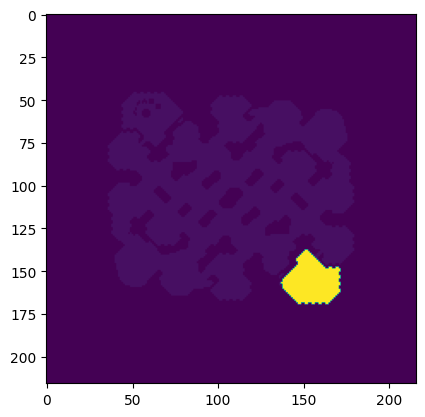

In [9]:
h = pathing_grid.copy()
for value in flood_fill(start_point, terrain_grid, pathing_grid, max_distance, set()):
    h[value] = 25
plt.imshow(h)

## Bounding Box

For the convolution slide over work we need a square like shape

In [10]:
%%cython
from cython cimport boundscheck, wraparound
# The boundscheck(False) decorator tells Cython that we know that we will not access elements outside the bounds of the units list, which allows for faster indexing. 
# The wraparound(False) decorator tells Cython that we know that we will not use negative indices to access elements of the list, which also allows for faster indexing.
@boundscheck(False)
@wraparound(False)
cpdef ((float, float), (float, float)) get_bounding_box(set coordinates):
    cdef:
        float x_min = 9999.0
        float x_max = 0.0
        float x_val = 0.0
        float y_min = 9999.0
        float y_max = 0.0
        float y_val = 0.0
        int start = 0
        Py_ssize_t stop = len(coordinates)
        (float, float) position
    for i in range(start, stop):
        position = coordinates.pop()
        x_val = position[0]
        y_val = position[1]
        if x_val < x_min:
            x_min = x_val
        if x_val > x_max:
            x_max = x_val
        if y_val < y_min:
            y_min = y_val
        if y_val > y_max:
            y_max = y_val
    return (x_min, x_max), (y_min, y_max)

In [11]:
%timeit -r 1000 -n 10 get_bounding_box(flood_fill(start_point, terrain_grid, pathing_grid, max_distance, set()))

287 µs ± 9.02 µs per loop (mean ± std. dev. of 1000 runs, 10 loops each)


In [12]:
raw_x_bounds, raw_y_bounds = get_bounding_box(flood_fill(start_point, terrain_grid, pathing_grid, max_distance, set()))

# Find building locations with convolution pass
Now we want to find a building formation given a bounding box

In [13]:
%%cython

from scipy.signal import convolve2d
import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cpdef bint can_place_structure(
    (int, int) building_origin,
    (int, int) building_size,
    const unsigned char[:, :] creep_grid,
    const unsigned char[:, :] placement_grid,
    const unsigned char[:, :] pathing_grid,
    bint avoid_creep = 1,
    bint include_addon = 0
):
    cdef:
        unsigned int size_x = building_size[0]
        unsigned int size_y = building_size[1]
        unsigned int x = building_origin[0]
        unsigned int y = building_origin[1]
        unsigned int total = 0
        unsigned int area = size_x * size_y
        unsigned int creep_check = 1 if avoid_creep else 0
    
    cdef Py_ssize_t i, j
    for i in range(size_y):
        for j in range(size_x):
            if placement_grid[y + i, x + j] == 0:
                return 0
            if creep_grid[y + i, x + j] == creep_check:
                return 0
            if pathing_grid[y + i, x + j] == 1:
                return 0
    return 1

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cpdef list find_building_locations(
    np.ndarray[np.uint8_t, ndim=2] kernel,
    unsigned int x_stride,
    unsigned int y_stride,
    (unsigned int, unsigned int) x_bounds,
    (unsigned int, unsigned int) y_bounds,
    const unsigned char[:, :] creep_grid,
    const unsigned char[:, :] placement_grid,
    const unsigned char[:, :] pathing_grid,
    const unsigned char[:, :] points_to_avoid_grid,
    unsigned int building_width,
    unsigned int building_height,
    bint avoid_creep = 1,
    bint include_addon = 0
):
    """
    Use a convolution pass to find all possible building locations in an area
    See full docs in `placement_solver.pyi`
    """
    cdef:
        # unsigned int i = 0
        # unsigned int j = 0
        unsigned int _x = 0
        unsigned int _y = 0
        unsigned int valid_idx = 0
        float x, y
        float weighted_x, weighted_y
        int x_min = x_bounds[0]
        int x_max = x_bounds[1]
        int y_min = y_bounds[0]
        int y_max = y_bounds[1]
        unsigned char[:, :] to_convolve = np.ones((x_max - x_min + 1, y_max - y_min + 1), dtype=np.uint8)
        (float, float) [500] valid_spots
        (float, float) center
        float half_width = building_width / 2
        cdef bint avoid = 0
    
    cdef Py_ssize_t i, j
    for i in range(x_min, x_max + 1):
        for j in range(y_min, y_max + 1):
            if points_to_avoid_grid[j][i] == 0 and creep_grid[j][i] == 0 and placement_grid[j][i] == 1 and pathing_grid[j][i] == 1:
                to_convolve[i - x_min][j - y_min] = 0

    cdef unsigned char[:, :] result = convolve2d(to_convolve, kernel, mode="valid")
    cdef Py_ssize_t k, l
    
    for i in range(0, result.shape[0], x_stride):
        for j in range(0, result.shape[1], y_stride):
            if result[i][j] == 0:
                x = i + x_min + half_width
                y = j + y_min + half_width

                if include_addon:
                    _x = int(x + 1.5)
                    _y = int(y + 0.5)
                    if not can_place_structure((_x, _y), (2, 2), creep_grid, placement_grid, pathing_grid, avoid_creep):
                        continue
                    
                    avoid = 0
                    for k in range(2):
                        for l in range(2):
                            if points_to_avoid_grid[_y+k, _x+l]:
                                avoid = 1
                    if avoid:
                        continue

                # valid building placement is building center, so add half to x and y
                valid_spots[valid_idx][0] = x
                valid_spots[valid_idx][1] = y
                valid_idx += 1

    if valid_idx == 0:
        return []

    return list(valid_spots)[:valid_idx]

### Example of how to use this:

In [14]:
# kernel is the size of the structure (3x3 for barracks, factor and starport for example)
kernel: np.ndarray = np.ones(
            (3, 3), dtype=np.uint8
        )

# pass in numpy array of points that find_building_locations should avoid using
points_to_avoid_grid = np.zeros(bot.game_info.placement_grid.data_numpy.shape, dtype=np.uint8)

# avoid within 5.5 distance of base location
start_x = int(bot.townhalls[0].position.x - 5.5)
start_y = int(bot.townhalls[0].position.y - 5.5)
points_to_avoid_grid[start_x:start_x+11, start_y:start_y+11] = 1

production_positions = find_building_locations(
    kernel, 
    5,
    3,
    raw_x_bounds, 
    raw_y_bounds, 
    bot.state.creep.data_numpy, 
    bot.game_info.placement_grid.data_numpy,
    pathing_grid,
    # bot.game_info.pathing_grid.data_numpy, 
    points_to_avoid_grid, 
    3, 
    3,
    True
)
print(production_positions)

[(139.5, 138.5), (144.5, 153.5), (149.5, 147.5), (149.5, 150.5), (149.5, 153.5), (149.5, 156.5), (149.5, 159.5), (154.5, 144.5), (154.5, 147.5), (154.5, 150.5), (154.5, 153.5), (154.5, 156.5), (154.5, 159.5), (154.5, 162.5), (154.5, 165.5), (159.5, 147.5), (159.5, 150.5), (159.5, 153.5), (159.5, 156.5), (159.5, 159.5), (159.5, 162.5), (159.5, 165.5), (164.5, 144.5), (164.5, 150.5), (164.5, 153.5), (164.5, 156.5), (164.5, 159.5), (164.5, 162.5), (164.5, 165.5)]


#### Now we have a list of all found 3x3 building positions in our main base

In [15]:
%timeit -r 1000 -n 10 can_place_structure((25, 25), (3, 3), bot.state.creep.data_numpy, bot.game_info.placement_grid.data_numpy, pathing_grid)

The slowest run took 4.18 times longer than the fastest. This could mean that an intermediate result is being cached.
878 ns ± 86.5 ns per loop (mean ± std. dev. of 1000 runs, 10 loops each)


In [16]:
%timeit -r 1000 -n 10 find_building_locations(kernel, 5,3, raw_x_bounds, raw_y_bounds, bot.state.creep.data_numpy, bot.game_info.placement_grid.data_numpy, pathing_grid, points_to_avoid_grid, 3, 3,True)

55.8 µs ± 2.29 µs per loop (mean ± std. dev. of 1000 runs, 10 loops each)


## Example of how placement locations could be stored
How could we use this information in our bot?

#### See `placement_manager._solve_terran_building_formation()` in `ares-sc2` for example building formation logic and tracking.

In [17]:
# store info in a dictionary
# the main keys are all expansion locations, and the value is a dictionary containing info about placements at that location
placements_dict: dict[Point2: dict] = dict()

placements_dict[bot.townhalls[0].position] = {}
placements_dict[bot.townhalls[0].position]["3x3"] = {}

for pos in production_positions:
    x: float = pos[0]
    y: float = pos[1]
    point2_pos: Point2 = Point2((x, y))
    placements_dict[bot.townhalls[0].position]["3x3"][point2_pos] = {
                        "available": True,
                        "has_addon": False,
                        "is_wall": False,
                        "tag": 0, # structure tag if not available
                        "worker_on_route": False # available but recently requested
                    }

In [18]:
# in our bot we can keep track of what's going on at each building location
placements_dict

{(58.5,
  58.5): {'3x3': {(139.5, 138.5): {'available': True,
    'has_addon': False,
    'is_wall': False,
    'tag': 0,
    'worker_on_route': False},
   (144.5, 153.5): {'available': True,
    'has_addon': False,
    'is_wall': False,
    'tag': 0,
    'worker_on_route': False},
   (149.5, 147.5): {'available': True,
    'has_addon': False,
    'is_wall': False,
    'tag': 0,
    'worker_on_route': False},
   (149.5, 150.5): {'available': True,
    'has_addon': False,
    'is_wall': False,
    'tag': 0,
    'worker_on_route': False},
   (149.5, 153.5): {'available': True,
    'has_addon': False,
    'is_wall': False,
    'tag': 0,
    'worker_on_route': False},
   (149.5, 156.5): {'available': True,
    'has_addon': False,
    'is_wall': False,
    'tag': 0,
    'worker_on_route': False},
   (149.5, 159.5): {'available': True,
    'has_addon': False,
    'is_wall': False,
    'tag': 0,
    'worker_on_route': False},
   (154.5, 144.5): {'available': True,
    'has_addon': False,
    